<a href="https://colab.research.google.com/github/Kubenew/hrl-minimal/blob/main/Copy_of_ICM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cpu
Update 0 | Reward 0.97
Update 10 | Reward 0.96
Update 20 | Reward 0.96
Update 30 | Reward 0.96
Update 40 | Reward 0.96
Update 50 | Reward 0.95
Update 60 | Reward 0.95
Update 70 | Reward 0.95
Update 80 | Reward 0.95
Update 90 | Reward 0.94
Update 100 | Reward 0.94
Update 110 | Reward 0.94
Update 120 | Reward 0.94
Update 130 | Reward 0.94
Update 140 | Reward 0.94
Update 150 | Reward 0.94
Update 160 | Reward 0.94
Update 170 | Reward 0.93
Update 180 | Reward 0.93
Update 190 | Reward 0.93
Update 200 | Reward 0.93
Update 210 | Reward 0.93
Update 220 | Reward 0.93
Update 230 | Reward 0.93
Update 240 | Reward 0.93
Update 250 | Reward 0.93
Update 260 | Reward 0.93
Update 270 | Reward 0.93
Update 280 | Reward 0.93
Update 290 | Reward 0.93


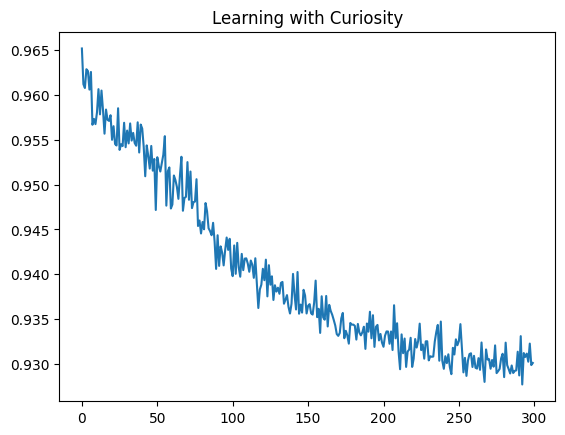

In [3]:
# Parallel Multi-Agent PPO + Curiosity (ICM) — Single Colab File

# GPU Compatible — Just Run All Cells

!pip -q install gymnasium torch numpy matplotlib

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================

# Config

# =========================

ENV_NAME = "CartPole-v1"
NUM_ENVS = 32
STEPS = 128
UPDATES = 300
GAMMA = 0.99
LR = 3e-4
ICM_BETA = 0.2          # weight of curiosity reward
ICM_LR = 1e-3

# =========================

# Vectorized Env

# =========================

envs = gym.vector.SyncVectorEnv([lambda: gym.make(ENV_NAME) for _ in range(NUM_ENVS)])
obs_dim = envs.single_observation_space.shape[0]
act_dim = envs.single_action_space.n

# =========================

# PPO Actor Critic

# =========================

class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim,128), nn.ReLU(),
            nn.Linear(128,128), nn.ReLU()
        )
        self.actor = nn.Linear(128,act_dim)
        self.critic = nn.Linear(128,1)

    def forward(self,x):
        x = self.shared(x)
        return self.actor(x), self.critic(x)

policy = ActorCritic().to(device)
optimizer = optim.Adam(policy.parameters(), lr=LR)

# =========================

# Curiosity Module (ICM)

# =========================

class ICM(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature = nn.Sequential(
            nn.Linear(obs_dim,128), nn.ReLU(),
            nn.Linear(128,128)
        )

        self.inverse = nn.Sequential(
            nn.Linear(256,256), nn.ReLU(),
            nn.Linear(256,act_dim)
        )

        self.forward_m = nn.Sequential(
            nn.Linear(128+act_dim,256), nn.ReLU(),
            nn.Linear(256,128)
        )

    def forward(self,s,a,s_next):
        phi_s = self.feature(s)
        phi_next = self.feature(s_next)

        # inverse model
        inv_input = torch.cat([phi_s,phi_next],dim=1)
        pred_a = self.inverse(inv_input)

        # forward model
        a_onehot = torch.nn.functional.one_hot(a,act_dim).float()
        f_input = torch.cat([phi_s,a_onehot],dim=1)
        pred_phi_next = self.forward_m(f_input)

        # curiosity reward
        intrinsic_reward = ((pred_phi_next - phi_next)**2).mean(dim=1)

        return intrinsic_reward, pred_a, pred_phi_next, phi_next

icm = ICM().to(device)
icm_opt = optim.Adam(icm.parameters(), lr=ICM_LR)

# =========================

# Training

# =========================

obs,_ = envs.reset()
obs = torch.tensor(obs,dtype=torch.float32).to(device)

reward_history=[]

for update in range(UPDATES):

    states=[]
    actions=[]
    rewards=[]
    dones=[]
    values=[]
    logps=[]

    for step in range(STEPS):

        logits,value = policy(obs)
        dist = Categorical(logits=logits)
        action = dist.sample()

        next_obs,ext_reward,done,trunc,_ = envs.step(action.cpu().numpy())

        next_obs_t = torch.tensor(next_obs,dtype=torch.float32).to(device)
        ext_reward = torch.tensor(ext_reward,dtype=torch.float32).to(device)
        done_t = torch.tensor(done|trunc,dtype=torch.float32).to(device)

        # ===== Curiosity reward =====
        intrinsic, pred_a, pred_phi, phi_next = icm(obs,action,next_obs_t)
        total_reward = ext_reward + ICM_BETA * intrinsic.detach()

        # store
        states.append(obs)
        actions.append(action)
        rewards.append(total_reward)
        dones.append(done_t)
        values.append(value.squeeze())
        logps.append(dist.log_prob(action))

        # ===== Train ICM =====
        inv_loss = nn.CrossEntropyLoss()(pred_a,action)
        fwd_loss = ((pred_phi - phi_next.detach())**2).mean()
        icm_loss = inv_loss + fwd_loss

        icm_opt.zero_grad()
        icm_loss.backward()
        icm_opt.step()

        obs = next_obs_t

    # ================= PPO UPDATE =================
    returns=[]
    R=0
    for r,d in zip(reversed(rewards),reversed(dones)):
        R=r + GAMMA*R*(1-d)
        returns.insert(0,R)

    returns=torch.stack(returns).view(-1)
    states=torch.cat(states)
    actions=torch.cat(actions)
    values=torch.cat(values)
    logps=torch.cat(logps)

    adv = returns-values.detach()

    logits,new_values = policy(states)
    dist = Categorical(logits=logits)
    new_logps = dist.log_prob(actions)

    ratio = torch.exp(new_logps-logps)
    surr1 = ratio*adv
    surr2 = torch.clamp(ratio,0.8,1.2)*adv
    actor_loss = -torch.min(surr1,surr2).mean()
    critic_loss = (returns-new_values.squeeze()).pow(2).mean()

    loss = actor_loss + 0.5*critic_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    mean_reward = torch.stack(rewards).mean().item()
    reward_history.append(mean_reward)

    if update%10==0:
        print(f"Update {update} | Reward {mean_reward:.2f}")

# ================= Plot

# =================

plt.plot(reward_history)
plt.title("Learning with Curiosity")
plt.show()